In [18]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, corr
import numpy as np
import pickle as pkl


In [19]:
spark_home = "D:\Ali_Other\Spark\spark_unzipped"
# spark_home = "D:/Boody/BigData/spark-3.5.1-bin-hadoop3"
os.environ["SPARK_HOME"] = spark_home

# Add Spark bin and executors to PATH
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "bin")
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "sbin")

# Add Spark Python libraries to PYTHONPATH
os.environ["PYTHONPATH"] = os.path.join(spark_home, "python") + os.pathsep + os.environ.get("PYTHONPATH", "")
os.environ["PYTHONPATH"] += os.pathsep + os.path.join(spark_home, "python", "lib")

# Add PySpark to the system path
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "python", "lib", "pyspark.zip")
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "python", "lib", "py4j-0.10.9-src.zip")

os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'lab'
os.environ['PYSPARK_PYTHON'] = 'python'

In [20]:

spark = SparkSession.builder \
    .appName("PySpark-Script") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

In [21]:
# Load the data
# data = spark.read.csv("D:/Boody/BigData/FIFA_Players_Analysis/Data/Preprocessed/Normalized_male_players (legacy)_23.csv", header=True, inferSchema=True)
data = spark.read.csv("Data/Preprocessed/Normalized_male_players (legacy)_23.csv", header=True, inferSchema=True)
# print data schema
data.printSchema()


root
 |-- player_id: integer (nullable = true)
 |-- fifa_version: double (nullable = true)
 |-- short_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: double (nullable = true)
 |-- potential: double (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: double (nullable = true)
 |-- height_cm: double (nullable = true)
 |-- weight_kg: double (nullable = true)
 |-- league_id: double (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: double (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- club_name: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: double (nullable = true)
 |-- club_contract_valid_until_year: double (nullable = true)
 |-- nationality_id: double (nullable = true)
 |-- nationality_name: string (nullable = true)
 |-- preferred_foot: double (nullable = true)
 |-- weak_foot: double (nullabl

In [22]:
K = 5
X = ['short_name', 'value_eur', 'wage_eur', 'international_reputation', 'overall', 'potential', 'movement_reactions', 'body_type_Unique', 'mentality_composure', 'rcm', 'cm', 'lcm', 'mentality_vision', 'ram', 'cam', 'lam', 'rm']



In [23]:
# Select the features
data = data.select(X)

# split the data into training and testing
train, test = data.randomSplit([0.8, 0.2])

# # Correlation matrix
# corr_matrix = np.zeros((len(X), len(X)))
# for i in range(1, len(X)):
#     for j in range(1, len(X)):
#         corr_matrix[i, j] = train.corr(X[i], X[j])


In [24]:
# # Split the train into features and labels
# # the features are X[2:] and the label is X[1]
# features = train.select(X[2:])
# label = train.select(X[1])

In [25]:
# Take one random sample from test
sample = test.sample(False, 0.1)   
# False y3ny mfeesh replacement tany, y3ny msh bye5tar el 7aga kaza mara
# 0.1 y3ny 10% mn el data hna5odha sample

# print it
# sample = sample.take(1)
print(sample.select(X[2:]).take(1))

[Row(wage_eur=0.007832898172323759, international_reputation=0.0, overall=0.4444444444444444, potential=0.4363636363636363, movement_reactions=0.6052631578947367, body_type_Unique=0.0, mentality_composure=0.5891666677255442, rcm=0.5584415584415585, cm=0.5584415584415585, lcm=0.5584415584415585, mentality_vision=0.5268817204301076, ram=0.5822784810126582, cam=0.5822784810126582, lam=0.5822784810126582, rm=0.6153846153846154)]


In [26]:
train_rdd = train.limit(250).rdd
# print size of train_rdd
print(train_rdd.count())

250


In [27]:
# def distance(record):
#     return np.sqrt(np.sum((record - sample) ** 2))

In [28]:
# Collect the necessary data from sample
testing_point = sample.collect()[0]

def CalculateDistance(x):
    distance = 0
    for i in range(2, len(x)):
        distance += (x[i] - testing_point[i]) ** 2
    return [x[1], np.sqrt(distance)]        # return overall and distance

distances = train_rdd.map(CalculateDistance)
print(distances.take(11))

# Sort the distances
# sorted_distances = distances.sortBy(lambda x: x)

# # Print the first 5 elements of the sorted RDD
# print(sorted_distances.take(5))
# [[0.523714338301096, 0.6511104530387805], 0.36612496930540456]

[[0.0386548384270022, 0.5643632573076596], [0.01494337599678349, 0.5453210935500289], [0.0023144449198191745, 0.15741609176274704], [0.0032165114253166253, 0.6200647096877453], [0.0025721782071041603, 0.296056253126469], [0.006695910803663937, 0.500520360685693], [0.009273243676513797, 0.3714979823271499], [0.0015412450579642164, 0.18026501391911756], [0.00978871025108377, 0.5012612315745572], [0.013396976273073572, 1.1177500889614287], [0.0025721782071041603, 0.2025535141234861]]


In [29]:
def sum_distances(a, b):
    # with open('txt.txt', 'a') as f:
    #     f.write(str(a))
    #     f.write('\n')
    return a + b

total_distance = distances.reduce(sum_distances)
print(total_distance)

[0.0386548384270022, 0.5643632573076596, 0.01494337599678349, 0.5453210935500289, 0.0023144449198191745, 0.15741609176274704, 0.0032165114253166253, 0.6200647096877453, 0.0025721782071041603, 0.296056253126469, 0.006695910803663937, 0.500520360685693, 0.009273243676513797, 0.3714979823271499, 0.0015412450579642164, 0.18026501391911756, 0.00978871025108377, 0.5012612315745572, 0.013396976273073572, 1.1177500889614287, 0.0025721782071041603, 0.2025535141234861, 0.0021855782761766814, 1.1466343827123617, 0.005664977654523993, 0.333180071260286, 0.006695910803663937, 1.1627970185225094, 0.0032165114253166253, 0.19699697035310007, 0.0019278449888916955, 0.5571610276708414, 0.0028299114943891464, 0.2851947688204798, 0.0021855782761766814, 1.2218339863760685, 0.0029587781380316395, 0.3075400786908125, 0.0029587781380316395, 0.21821141444204445, 0.0021855782761766814, 0.1914726397284967, 0.0036031113562441045, 0.14714169687842787, 0.0021855782761766814, 0.12934242926735634, 0.00192784498889169

In [30]:
def lister(a, b):
    array = []
    array.append(a)
    array.append(b)
    # return b
    return list(array)

In [31]:
# def flatten(xss):
    # return [x for xs in xss for x in xs]


def SortDistances(a, b):
    # append a and b
    a[0] = np.array(a[0]).flatten()
    a[0] = np.append(a[0], b[0])
    
    a[1] = np.array(a[1]).flatten()
    a[1] = np.append(a[1], b[1])

    # Pair up the elements of a[0] and a[1], sort the pairs based on the distances, and unzip the pairs
    # pairs = list(zip(a[0], a[1]))
    # pairs.sort(key=lambda x: x[1])
    # a[0], a[1] = zip(*pairs)
    
    pairs = list(zip(a[0], a[1]))
    pairs.sort(key=lambda x: x[1])
    pairs = pairs[:K]
    a[0], a[1] = zip(*pairs)


    return a[:K]
    


In [32]:
sorted_distances = distances.reduce(SortDistances)
print(sorted_distances)
# overall = (0.0030876447816741326, 0.0028299114943891464, 0.0029587781380316395, 0.0028299114943891464, 0.0029587781380316395)
# distance = (0.06872744576108634, 0.07144107503168742, 0.08268783790827565, 0.08911705093707586, 0.0947481815495009)

[(0.0027010448507466533, 0.0019278449888916955, 0.0023144449198191745, 0.0021855782761766814, 0.0025721782071041603), (0.06524445638445908, 0.09597455119444656, 0.09602516211801906, 0.12934242926735634, 0.12937756194095337)]


In [33]:
predicted_value = np.mean(sorted_distances[0])
print(predicted_value)

0.0023402182485476727


R2 score

![1 _HbrAW-tMRBli6ASD5Bttw.webp](<attachment:1 _HbrAW-tMRBli6ASD5Bttw.webp>)

MAE

![1 9BhnZiaHkApC-gQt3rYpMQ.png](<attachment:1 9BhnZiaHkApC-gQt3rYpMQ.png>)

MSE

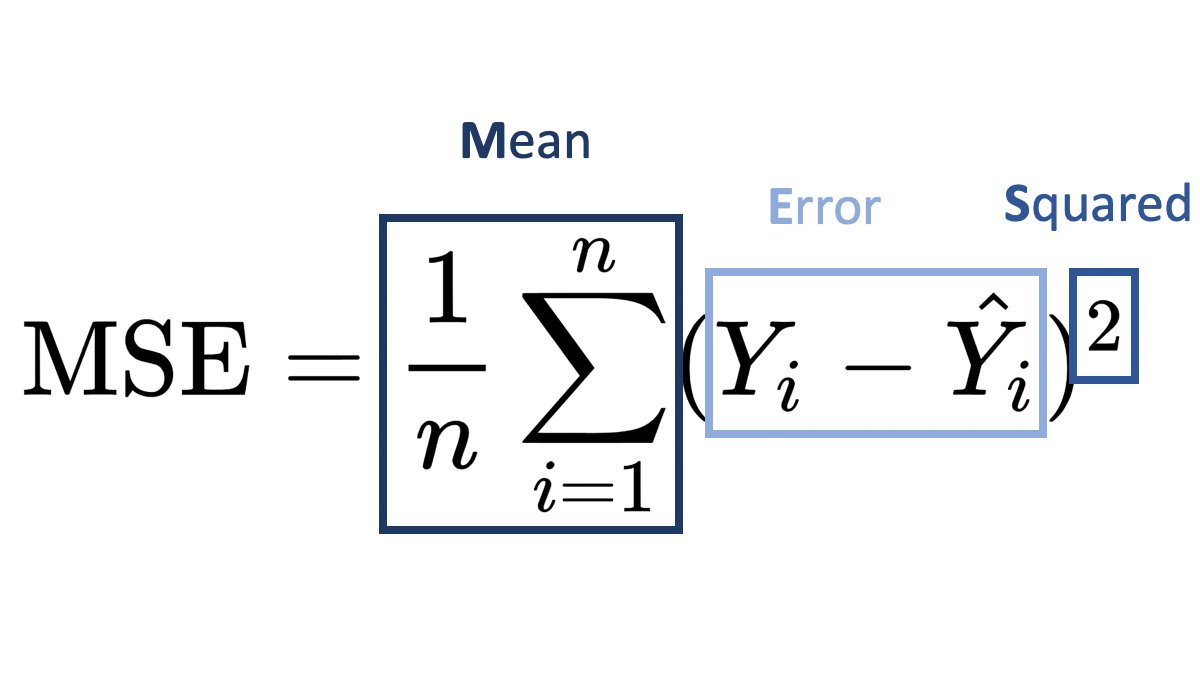
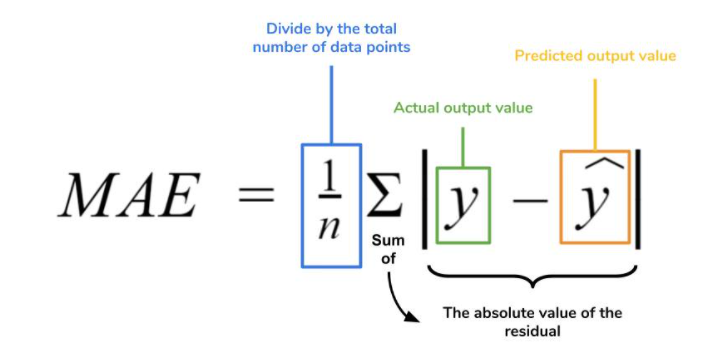
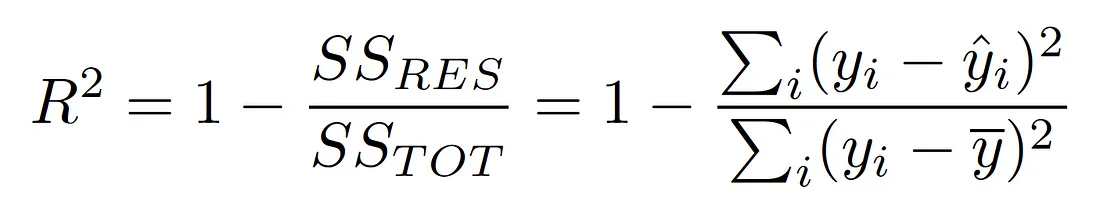

In [34]:
mae = 0
mse = 0
num = 0
denum = 0
y_mean = train_rdd.map(lambda x: x[1]).mean()
counter = 0
for testing_point in test.collect():
    try:
        counter += 1
        if counter % 50 == 0:
            print("counter:", counter)
            print("R2 score:", 1 - num / denum)
            print("MAE:", mae / counter)
            print("MSE:", mse / counter)
        testing_point = testing_point
        distances = train_rdd.map(CalculateDistance)
        sorted_distances = distances.reduce(SortDistances)
        predicted_value = np.mean(sorted_distances[0])
        # print(predicted_value)
        num += (testing_point[1] - predicted_value) ** 2
        denum += (testing_point[1] - y_mean) ** 2
        mae += abs(testing_point[1] - predicted_value)
        mse += (testing_point[1] - predicted_value) ** 2
        # print(f"predicted value {predicted_value}, actual value {testing_point[1]}, difference {testing_point[1] - predicted_value}")
    except Exception as e:
        print("error:", e)
        print("error at counter:", counter)
        print("R2 score:", 1 - num / denum)
        print("MAE:", mae / counter)
        print("MSE:", mse / counter)

r2 = 1 - num / denum
print("R2 score:", r2)
print("MAE:", mae / counter)
print("MSE:", mse / counter)



counter: 10
R2 score: 0.727225365163263
MAE: 0.0029175408120660413
MSE: 2.4458616482058035e-05
counter: 20
R2 score: 0.7796694825245349
MAE: 0.0030489847885813845
MSE: 2.4144220106633455e-05
counter: 30
R2 score: 0.7777368141712111
MAE: 0.0026417661946711063
MSE: 1.7835788968052312e-05
counter: 40
R2 score: 0.8207612298055084
MAE: 0.002214573270996242
MSE: 1.3822098202792016e-05
counter: 50
R2 score: 0.8772661028375079
MAE: 0.002732282125165593
MSE: 2.232351582266489e-05
counter: 60
R2 score: 0.8665544642691099
MAE: 0.0026729519224325893
MSE: 2.1230383693829745e-05
counter: 70
R2 score: 0.8726983121885902
MAE: 0.002717539781132892
MSE: 2.1921259045238296e-05
counter: 80
R2 score: 0.8595738971741148
MAE: 0.002768957571946247
MSE: 2.2065487469100668e-05
counter: 90
R2 score: 0.847126882966842
MAE: 0.003031458925046005
MSE: 2.457072218307746e-05
counter: 100
R2 score: 0.8498378107217343
MAE: 0.0028347568801901034
MSE: 2.225546378727001e-05


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
spark.stop()